In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score,\
         recall_score

In [3]:
from lightgbm import LGBMClassifier
import lightgbm

In [4]:
import plotly.express as px

In [5]:
#from sklearn.impute import KNNImputer

In [6]:
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#import category_encoders as ce

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [9]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [10]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [11]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [12]:
df_all = pd.read_csv('train_data.csv')

id в обучении не должен участвовать

In [13]:
df_all.target.value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

In [14]:
df_all.head(20)

,id,vas_id,buy_time_x,target,0,1,2,3,4,5,...,244,245,246,247,248,249,250,251,252,time_delta
0,540968,8.0,1537131600,0.0,-31.559970,327.360900,-45.500786,274.753200,-50.918247,253.648210,...,-613.77080,-20.99627,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.54386,0.0,-4838400
1,1454121,4.0,1531688400,0.0,547.270000,238.430900,533.329200,274.803200,527.911740,253.698210,...,-613.77080,-25.99627,-19.630450,-278.747700,-24.832888,-0.694429,-11.175933,-0.45614,0.0,604800
2,2458816,1.0,1534107600,0.0,-92.139970,-95.469110,-106.080790,-139.596800,-111.498245,-142.901800,...,-613.77080,-25.99627,-37.630447,-304.747700,-25.832888,-0.694429,-12.175933,-0.45614,0.0,-9072000
3,3535012,5.0,1535922000,0.0,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,...,-613.77080,-25.99627,-18.630450,-133.747730,-14.832889,-0.694429,-1.175933,-0.45614,0.0,2419200
4,1693214,1.0,1535922000,0.0,45.160030,295.240880,64.679214,344.283200,59.261753,323.178220,...,-612.77080,-22.99627,-32.630447,-127.747730,-4.832889,-0.694429,-12.175933,-0.45614,0.0,-7257600
5,3173665,8.0,1532898000,0.0,-67.149970,-372.599120,-81.090780,-425.206800,-86.508250,-446.311800,...,-613.77080,-25.99627,-37.630447,-306.747700,-25.832888,-0.694429,-12.175933,-0.45614,0.0,-4838400
6,2611143,2.0,1544994000,0.0,-96.799970,-408.179100,-110.740780,-460.786800,-116.158250,-481.891780,...,-613.77080,-25.99627,-37.630447,-306.747700,-25.832888,-0.694429,-12.175933,-0.45614,0.0,11491200
7,3577737,5.0,1545598800,0.0,-96.799970,-10.719112,-110.740780,-63.326797,-116.158250,-84.431790,...,-613.77080,-25.99627,-35.630447,-274.747700,106.167114,-0.694429,119.824066,-0.45614,1.0,14515200
8,2000856,1.0,1534712400,0.0,-21.369970,108.780890,178.619220,770.863200,173.201750,749.758240,...,-613.77080,-25.99627,-37.630447,-306.747700,-25.832888,-0.694429,-12.175933,-0.45614,0.0,3024000
9,1232876,2.0,1544994000,0.0,-39.399970,-59.939114,-53.340786,-112.546800,-58.758247,-133.651800,...,-453.77078,-24.99627,-37.630447,258.252300,-21.832888,-0.694429,-8.175933,-0.45614,0.0,12700800


In [15]:
df_all = df_all[[c for c
        in list(df_all)
        if len(df_all[c].unique()) > 1]] #Перезаписываем датасет, оставляя 
#только те колонки, в которых больше одного уникального значения

In [16]:
#df_all['vas_id'] = df_all['vas_id'].astype("int8")

In [17]:
df_numerical = df_all.select_dtypes(include = [np.number])
df_categorical = df_all.select_dtypes(exclude = [np.number])

In [18]:
# Ищу признаки категориальные среди вещественных
select_spy = pd.DataFrame(df_numerical.nunique())

In [19]:
list_spy = select_spy.loc[select_spy[0] < 11].index.to_list()

In [20]:
list_spy.remove('target')

In [21]:
df_categorical = df_all[list_spy]

In [22]:
df_numerical.drop(labels=list_spy, axis=1, inplace = True)
#вырезаем эти колонки из количественных данных

In [23]:
df_numerical.drop(labels=['target'], axis=1, inplace = True)

In [24]:
# где у нас нули
for i in df_numerical.columns:
    print(i, df_all[i][df_all[i]==0].count())

id 0
buy_time_x 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
24 0
25 0
28 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
76 0
77 0
78 0
79 0
80 0
82 0
83 0
84 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
133 0
134 0
135 0
136 0
137 0
138 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0
185 0
186 0
187 0
188 0
189 0
190 0
191 0
193 0
207 0
208 0
209 0
210 0
211 

Колонку  id все таки решил оставить. Модели нужно знать каким юзерам предлагалось несколько услуг.

In [25]:
# Проверка
Categorical_features = df_all.select_dtypes(exclude=['float','int'])

In [26]:
cat_feats = Categorical_features.columns.to_list()

In [27]:
cat_feats

[]

Буду сразу ориентироваться на троицу из градиентных бустингов, ну и  Random Forest. Поэтому в качестве базовой модели возьму LGBMClassifier, т.к. он из всех бустингов самый легкий. Коли light, пусть летает.

In [28]:
def choise_features(data):
    X = data.drop(columns=['target'])
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    lgb = LGBMClassifier(objective='binary',
                        n_estimators=50, 
                         max_depth=3, 
                         metric = "f1",
                         categorical_feature=cat_feats
                        )

    
    lgb.fit(X_train, y_train)


    evaluate_preds(lgb, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, lgb.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return X_train, X_test, y_train, y_test, feature_importances

Предварительно проверил, что дамми-признаки на метрику не влияют

'vas_id' тоже разобью на дамми-признаки, чтобы модель знала, что юзеру уже предлагались другие услуги. Предварительно проверил, метрику это не ухудшило.

In [29]:
df_all[list_spy] = df_all[list_spy].astype('object')

In [30]:
categorical_features = df_all.select_dtypes(include=['object']).columns.to_list()

In [31]:
categorical_features.remove('vas_id')

Для кактегориальных признаков уберу редкоприменяемые значения в значение  Rare. Предварительно проверил, метрику это не ухудшило.

In [32]:
from feature_engine.encoding import RareLabelEncoder

In [33]:
rare_encoder = RareLabelEncoder(tol=0.03, n_categories=2, variables= categorical_features)

In [34]:
df_all[categorical_features] = rare_encoder.fit_transform(df_all[categorical_features])
#rare_encoder.transform(X_test)

/home/jb/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:179: UserWarning: The number of unique categories for variable 26 is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/home/jb/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:179: UserWarning: The number of unique categories for variable 27 is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/home/jb/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:179: UserWarning: The number of unique categories for variable 31 is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/home/jb/anaconda3/lib/python3.8/site-packages/feature_engine/encoding/rare_label.py:179: UserWarning: The number of unique categories for variable 32 is less than that indicated in n_categories. Thus, all categori

In [35]:
df_all['15'].value_counts()

-0.00072525424    831637
Rare                  16
Name: 15, dtype: int64

Таким образом, применив RareLabelEncoder  можно увеличить количество категориальных признаков.

Проверил какой энкодер дает лучшую метрику. Почти все одинаковую. Скорее всего это говорит о том, что категориальные признаки не имеют высокую важность. Перетянул этот код наверх, чтобы показать логику принятия решения. И принял решение  чтобы сэкономить время категориальные признаки не исследовать.

In [36]:
#encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
##               ce.basen.BaseNEncoder,
##               ce.binary.BinaryEncoder,
##                ce.cat_boost.CatBoostEncoder,
##                ce.hashing.HashingEncoder,
##                ce.helmert.HelmertEncoder,
##                ce.james_stein.JamesSteinEncoder,
##                ce.one_hot.OneHotEncoder,
##                ce.leave_one_out.LeaveOneOutEncoder,
##                ce.m_estimate.MEstimateEncoder,
##                ce.ordinal.OrdinalEncoder,
##                ce.polynomial.PolynomialEncoder,
##                ce.sum_coding.SumEncoder,
#                ce.target_encoder.TargetEncoder,
#                ce.woe.WOEEncoder
#                ]

In [37]:
#df_all[list_spy] = df_all[list_spy].astype('object')
#y = df_all['target']
#X = df_all.drop(columns=['target'])
#numeric_features = X.select_dtypes(include=['int', 'float']).columns
#categorical_features = X.select_dtypes(include=['object']).columns

In [38]:
#le = preprocessing.LabelEncoder()
#label_encoder = le.fit(y)
#y = label_encoder.transform(y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
#for encoder in encoder_list#:
#    
#    numeric_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler())])
#    categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#    ('woe', encoder())])
#    
#    preprocessor = ColumnTransformer(
#    transformers=[
 #       ('num', numeric_transformer, numeric_features),
#        ('cat', categorical_transformer, categorical_features)])
#    
#    pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                      ('classifier', LGBMClassifier(objective='binary',
#                        n_estimators=50, 
#                        max_depth=3, 
#                         metric = "f1"))])
#    
#    model = pipe.fit(X_train, y_train)
#    y_pred = model.predict(X_test)
#    print(encoder)
#    print(f1_score(y_test, y_pred, average='macro'))

<class 'category_encoders.backward_difference.BackwardDifferenceEncoder'> 0.6344820159287033

<class 'category_encoders.basen.BaseNEncoder'> 0.6344820159287033

<class 'category_encoders.binary.BinaryEncoder'> 0.6344820159287033

<class 'category_encoders.cat_boost.CatBoostEncoder'> 0.6344820159287033

<class 'category_encoders.hashing.HashingEncoder'> 0.6344820159287033

<class 'category_encoders.helmert.HelmertEncoder'> 0.6344820159287033

<class 'category_encoders.james_stein.JamesSteinEncoder'> 0.6344820159287033

<class 'category_encoders.one_hot.OneHotEncoder'> 0.6344820159287033

<class 'category_encoders.leave_one_out.LeaveOneOutEncoder'> 0.4288610038610039

<class 'category_encoders.m_estimate.MEstimateEncoder'> 0.6344820159287033

<class 'category_encoders.ordinal.OrdinalEncoder'> 0.6344820159287033

<class 'category_encoders.polynomial.PolynomialEncoder'> 0.6344820159287033

<class 'category_encoders.sum_coding.SumEncoder'> 0.6344820159287033

<class 'category_encoders.target_encoder.TargetEncoder'> 0.6344820159287033

<class 'category_encoders.woe.WOEEncoder'> 0.6344820159287033


Чтобы упростить код, если нет разницы применю get_dummies

In [40]:
df_all = pd.get_dummies(df_all, prefix=list_spy)

In [41]:
X_train, X_test, y_train, y_test, feature_importances = choise_features(df_all)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

0.0    0.92763
1.0    0.07237
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    540027
         1.0       0.73      0.21      0.33     42130

    accuracy                           0.94    582157
   macro avg       0.84      0.60      0.65    582157
weighted avg       0.93      0.94      0.92    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231440
         1.0       0.74      0.22      0.34     18056

    accuracy                           0.94    249496
   macro avg       0.84      0.61      0.65    249496
weighted avg       0.93      0.94      0.92    249496

CONFUSION MATRIX

col_0      0.0   1.0
target              
0.0     230077  1363
1.0      14143  3913


  macro avg       0.82      0.60      0.65    258016

macro avg чет не радует. 

In [42]:
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,buy_time_x,157
224,vas_id_4.0,51
226,vas_id_6.0,48
0,id,40
222,vas_id_1.0,12
...,...,...
105,117,0
106,118,0
107,119,0
108,120,0


Проверяю версию, что buy_time одно и то же для фрейма ddf и df. На выходе одни  Nan, версия отменяется.

In [44]:
#df_all2 = df.merge(ddf, how='left', on=['id', 'buy_time'])

In [45]:
#df_all2.head()

In [46]:
# нет, это не наш метод
#df_all2.isna().sum().sum()

# ДОБАВЛЯЮ ПРИЗНАКИ ПО ВРЕМЕНИ

In [47]:
df_all.head()

,id,buy_time_x,target,0,1,2,3,4,5,6,...,204_-0.9607925,204_0.039207514,205_-0.3343556,205_0.6656444,206_-0.008998504,206_0.9910015,216_-8.332358e-05,216_Rare,218_-4.033216e-05,218_Rare
0,540968,1537131600,0.0,-31.559970,327.360900,-45.500786,274.753200,-50.918247,253.64821,49.15382,...,0,1,0,1,1,0,1,0,1,0
1,1454121,1531688400,0.0,547.270000,238.430900,533.329200,274.803200,527.911740,253.69821,-16.08618,...,0,1,0,1,1,0,1,0,1,0
2,2458816,1534107600,0.0,-92.139970,-95.469110,-106.080790,-139.596800,-111.498245,-142.90180,-16.08618,...,0,1,0,1,1,0,1,0,1,0
3,3535012,1535922000,0.0,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.22179,60.17382,...,0,1,0,1,1,0,1,0,1,0
4,1693214,1535922000,0.0,45.160030,295.240880,64.679214,344.283200,59.261753,323.17822,-16.08618,...,0,1,0,1,1,0,1,0,1,0


In [48]:
#!pip3 install holidays

In [49]:
from datetime import datetime, date, time
from datetime import timedelta
import holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [50]:
# построили список всех праздников
one_day = timedelta(days=1)
cal = calendar()

In [51]:
def get_holidays(XX):
    # список всех предыдущих и следующих дней для праздников
    prev_holiday = ([str( d.date() - one_day ) for d in cal.holidays()])
    next_holiday = ([str( d.date() + one_day ) for d in cal.holidays()])
    
    # взяли все даты из train и test
    dates = XX['date'].value_counts().index
    
    # у нас дат не так много, посмотрим на них руками
    for i in dates:
        if str(i) in prev_holiday:
            print("prev_holiday",i)
        if str(i) in next_holiday:
            print("next_holiday",i)
        if i in cal.holidays():
            print("holidays",i)

In [52]:
# добавляем новые столбцы по датам
def date_columns(XX):
    # месяц
    XX['month'] = XX['buy_time_x'].apply(lambda x: date.fromtimestamp(x).month)
    # день
    XX['day'] = XX['buy_time_x'].apply(lambda x: date.fromtimestamp(x).day)
    # день года. 
    # день недели бесполезен - тут одни понедельники
    XX['dayofyear'] = XX['buy_time_x'].apply(lambda x: pd.to_datetime(date.fromtimestamp(x)).dayofyear)
    # неделя года
    XX['weekofyear'] = XX['buy_time_x'].apply(lambda x: pd.to_datetime(date.fromtimestamp(x)).weekofyear)
    
    # день перед праздником
    XX['is_prev_holiday'] = 0
    XX.loc[XX['date']=='2018-12-31','is_prev_holiday'] = 1 
    XX.loc[XX['date']=='2018-12-24','is_prev_holiday'] = 1

    # отдельно пометим день перед новым годом
    XX['is_prev_newyear'] = 0
    XX.loc[XX['date']=='2018-12-31','is_prev_newyear'] = 1
    
    # собственно сам праздник
    # праздники есть и в train и в test
    XX['is_holiday'] = 0
    XX.loc[XX['date']=='2018-10-08','is_holiday'] = 1
    XX.loc[XX['date']=='2018-09-03','is_holiday'] = 1
    XX.loc[XX['date']=='2018-11-12','is_holiday'] = 1
    XX.loc[XX['date']=='2019-01-21','is_holiday'] = 1
    

In [53]:
df_all['date'] = df_all['buy_time_x'].apply(lambda x: date.fromtimestamp(x))

In [54]:
df_all['date'] = df_all['date'].astype(str)

In [55]:
get_holidays(df_all)

prev_holiday 2018-12-24
prev_holiday 2018-12-31
holidays 2018-09-03
holidays 2018-10-08
holidays 2018-11-12


In [56]:
# добавляем новые столбцы по датам
date_columns(df_all)

In [57]:
df_all.drop(columns=['date'], inplace=True)

In [58]:
df_all.drop(columns=['buy_time_x'], inplace=True)

In [59]:
df_all.head()

,id,target,0,1,2,3,4,5,6,7,...,216_Rare,218_-4.033216e-05,218_Rare,month,day,dayofyear,weekofyear,is_prev_holiday,is_prev_newyear,is_holiday
0,540968,0.0,-31.559970,327.360900,-45.500786,274.753200,-50.918247,253.64821,49.15382,195.883900,...,0,1,0,9,17,260,38,0,0,0
1,1454121,0.0,547.270000,238.430900,533.329200,274.803200,527.911740,253.69821,-16.08618,-65.076096,...,0,1,0,7,16,197,29,0,0,0
2,2458816,0.0,-92.139970,-95.469110,-106.080790,-139.596800,-111.498245,-142.90180,-16.08618,-65.076096,...,0,1,0,8,13,225,33,0,0,0
3,3535012,0.0,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.22179,60.17382,87.453900,...,0,1,0,9,3,246,36,0,0,1
4,1693214,0.0,45.160030,295.240880,64.679214,344.283200,59.261753,323.17822,-16.08618,-65.076096,...,0,1,0,9,3,246,36,0,0,1


Распределение уникальных значений признаков

In [140]:
df_all_nunique = df_all.apply(lambda x: x.nunique(dropna=False))

In [141]:
df_all_nunique.shape

(301,)

In [142]:
df_all_nunique

id                 806613
target                  2
0                   46162
1                  112909
2                   56508
                    ...  
dayofyear              26
weekofyear             26
is_prev_holiday         2
is_prev_newyear         2
is_holiday              2
Length: 301, dtype: int64

In [143]:
import plotly.express as px
import matplotlib.pyplot as plt

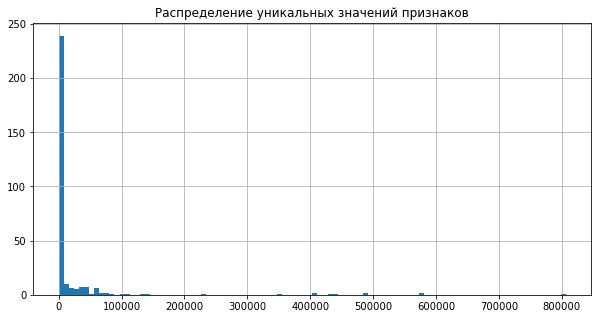

In [144]:
plt.title("Распределение уникальных значений признаков");
df_all_nunique.hist(bins=100, figsize=(10, 5));

In [66]:
f_all = set(df_all_nunique.index.tolist())
len(f_all)

294

Распределение покупок по дням

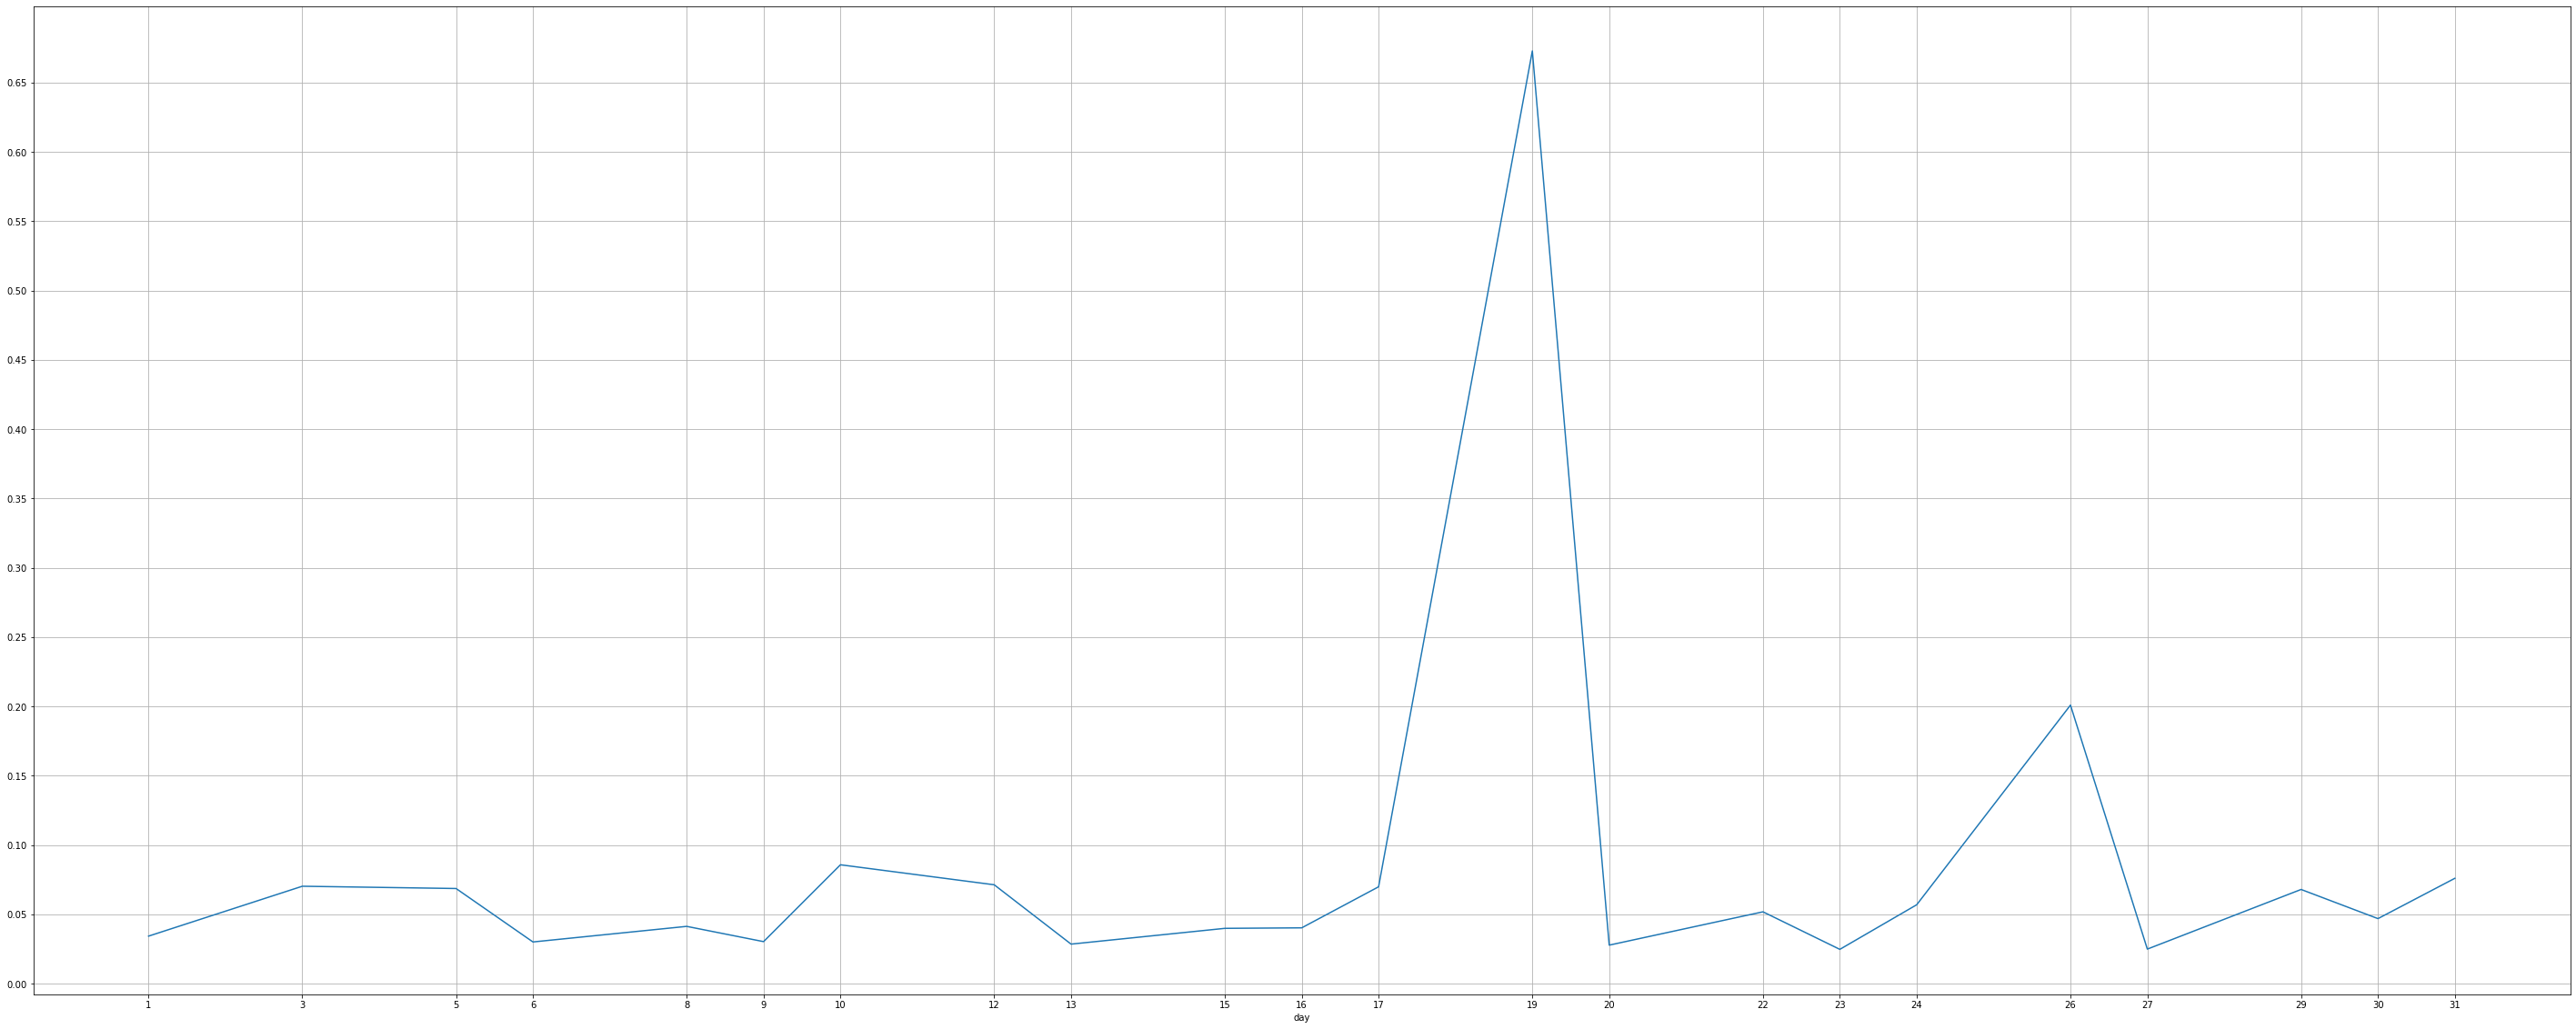

In [67]:
plt.figure(figsize=(50, 20))
df_all.groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(df_all['day'].unique())
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

Здесь наблюдается один крупный выброс и выброс поменьше, но на соответствующих графиках датафреймов, разбитых по  vas_id выброс единичный. Значит принимать решение что это аналогичные акции было бы ошибкой.

Посмотрю какое распределение фрейма по vas_id.

# vas_id==1

In [68]:
df_1 = df_all[df_all['vas_id_1.0']==1]

In [69]:
X_train1, X_test1, y_train1, y_test1, feature_importances1 = choise_features(df_1)

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

0.0    0.981742
1.0    0.018258
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    213157
         1.0       0.56      0.40      0.46      3965

    accuracy                           0.98    217122
   macro avg       0.77      0.69      0.73    217122
weighted avg       0.98      0.98      0.98    217122

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     91354
         1.0       0.54      0.39      0.45      1699

    accuracy                           0.98     93053
   macro avg       0.76      0.69      0.72     93053
weighted avg       0.98      0.98      0.98     93053

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     90788  566
1.0      1032  667


macro avg       0.77      0.69      0.72     93053

In [70]:
feature_importances1[:20].sort_values(by='importance', ascending=False)

,feature_name,importance
0,id,94
2,1,2
3,2,2
9,8,2
4,3,1
7,6,1
15,14,1
11,10,1
13,12,0
18,18,0


In [71]:
fea_imp1 = feature_importances1[feature_importances1['importance'] > 1]['feature_name'].to_list()

# vas_id==2

In [72]:
df_2 = df_all[df_all['vas_id_2.0']==1]
X_train2, X_test2, y_train2, y_test2, feature_importances2 =\
     choise_features(df_2)

0.0    0.980773
1.0    0.019227
Name: target, dtype: float64

0.0    0.980775
1.0    0.019225
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    171295
         1.0       0.66      0.55      0.60      3358

    accuracy                           0.99    174653
   macro avg       0.83      0.77      0.80    174653
weighted avg       0.98      0.99      0.99    174653

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     73413
         1.0       0.64      0.53      0.58      1439

    accuracy                           0.99     74852
   macro avg       0.82      0.76      0.79     74852
weighted avg       0.98      0.99      0.98     74852

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     72991  422
1.0       677  762


macro avg       0.83      0.77      0.80     74852

In [73]:
feature_importances2[:10].sort_values(by='importance', ascending=False)

,feature_name,importance
0,id,26
2,1,1
1,0,0
3,2,0
4,3,0
5,4,0
6,5,0
7,6,0
8,7,0
9,8,0


# vas_id==4

In [74]:
df_4 = df_all[df_all['vas_id_4.0']==1]
X_train4, X_test4, y_train4, y_test4, feature_importances4 =\
     choise_features(df_4)

0.0    0.746206
1.0    0.253794
Name: target, dtype: float64

0.0    0.746181
1.0    0.253819
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88     44794
         1.0       0.80      0.26      0.39     15235

    accuracy                           0.79     60029
   macro avg       0.79      0.62      0.63     60029
weighted avg       0.79      0.79      0.75     60029

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88     19197
         1.0       0.80      0.26      0.40      6530

    accuracy                           0.80     25727
   macro avg       0.80      0.62      0.64     25727
weighted avg       0.80      0.80      0.76     25727

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     18763   434
1.0      4810  1720


macro avg       0.80      0.62      0.63     26626

In [75]:
feature_importances4[:10].sort_values(by='importance', ascending=False)

,feature_name,importance
0,id,66
4,3,4
1,0,3
2,1,2
5,4,1
8,7,1
9,8,1
3,2,0
6,5,0
7,6,0


# vas_id==5

In [76]:
df_5 = df_all[df_all['vas_id_5.0']==1]
X_train5, X_test5, y_train5, y_test5, feature_importances5 =\
     choise_features(df_5)

0.0    0.982022
1.0    0.017978
Name: target, dtype: float64

0.0    0.982002
1.0    0.017998
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     64675
         1.0       0.69      0.58      0.63      1184

    accuracy                           0.99     65859
   macro avg       0.84      0.79      0.81     65859
weighted avg       0.99      0.99      0.99     65859

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     27718
         1.0       0.67      0.50      0.57       508

    accuracy                           0.99     28226
   macro avg       0.83      0.75      0.78     28226
weighted avg       0.99      0.99      0.99     28226

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     27593  125
1.0       253  255


macro avg       0.83      0.77      0.80     28226

In [77]:
feature_importances5[:10].sort_values(by='importance', ascending=False)

,feature_name,importance
0,id,75
1,0,13
2,1,6
9,8,5
3,2,4
8,7,2
5,4,1
6,5,1
7,6,1
4,3,0


# vas_id==6

In [78]:
df_6 = df_all[df_all['vas_id_6.0']==1]
X_train6, X_test6, y_train6, y_test6, feature_importances6 =\
     choise_features(df_6)

0.0    0.57316
1.0    0.42684
Name: target, dtype: float64

0.0    0.573197
1.0    0.426803
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.60      0.97      0.74     23221
         1.0       0.75      0.11      0.20     17293

    accuracy                           0.61     40514
   macro avg       0.67      0.54      0.47     40514
weighted avg       0.66      0.61      0.51     40514

TEST

              precision    recall  f1-score   support

         0.0       0.59      0.96      0.73      9953
         1.0       0.69      0.11      0.19      7411

    accuracy                           0.60     17364
   macro avg       0.64      0.54      0.46     17364
weighted avg       0.64      0.60      0.50     17364

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     9592  361
1.0     6592  819


macro avg       0.67      0.53      0.44     17364

In [79]:
feature_importances6[:10].sort_values(by='importance', ascending=False)

,feature_name,importance
0,id,38
2,1,2
6,5,2
7,6,2
8,7,2
1,0,0
3,2,0
4,3,0
5,4,0
9,8,0


# vas_id==7

In [80]:
df_7 = df_all[df_all['vas_id_7.0']==1]
X_train7, X_test7, y_train7, y_test7, feature_importances7 =\
     choise_features(df_7)

0.0    0.986206
1.0    0.013794
Name: target, dtype: float64

0.0    0.986177
1.0    0.013823
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     10653
         1.0       0.83      0.40      0.54       149

    accuracy                           0.99     10802
   macro avg       0.91      0.70      0.77     10802
weighted avg       0.99      0.99      0.99     10802

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      4566
         1.0       0.64      0.42      0.51        64

    accuracy                           0.99      4630
   macro avg       0.82      0.71      0.75      4630
weighted avg       0.99      0.99      0.99      4630

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     4551   15
1.0       37   27


   macro avg       0.76      0.66      0.70      4630

In [81]:
feature_importances7[:20].sort_values(by='importance', ascending=False)

,feature_name,importance
0,id,17
2,1,6
19,19,5
5,4,2
1,0,2
3,2,0
13,12,0
18,18,0
17,17,0
16,16,0


# vas_id==8

In [82]:
df_8 = df_all[df_all['vas_id_8.0']==1]
X_train8, X_test8, y_train8, y_test8, feature_importances8 =\
     choise_features(df_8)

0.0    0.973997
1.0    0.026003
Name: target, dtype: float64

0.0    0.974032
1.0    0.025968
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      9102
         1.0       0.79      0.88      0.83       243

    accuracy                           0.99      9345
   macro avg       0.89      0.94      0.91      9345
weighted avg       0.99      0.99      0.99      9345

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3901
         1.0       0.65      0.86      0.74       104

    accuracy                           0.98      4005
   macro avg       0.83      0.92      0.87      4005
weighted avg       0.99      0.98      0.99      4005

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     3854   47
1.0       15   89


macro avg       0.82      0.83      0.82      4005

In [83]:
feature_importances8[:20].sort_values(by='importance', ascending=False)

,feature_name,importance
0,id,11
6,5,5
9,8,4
18,18,4
4,3,3
5,4,3
15,14,2
12,11,1
19,19,1
2,1,1


# vas_id==9

In [84]:
df_9 = df_all[df_all['vas_id_9.0']==1]
X_train9, X_test9, y_train9, y_test9, feature_importances9 =\
     choise_features(df_9)

0.0    0.816449
1.0    0.183551
Name: target, dtype: float64

0.0    0.816687
1.0    0.183313
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      3127
         1.0       0.91      0.86      0.88       703

    accuracy                           0.96      3830
   macro avg       0.94      0.92      0.93      3830
weighted avg       0.96      0.96      0.96      3830

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1341
         1.0       0.92      0.86      0.89       301

    accuracy                           0.96      1642
   macro avg       0.94      0.92      0.93      1642
weighted avg       0.96      0.96      0.96      1642

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1318   23
1.0       41  260


macro avg       0.93      0.92      0.93      1642

In [85]:
feature_importances9[:20].sort_values(by='importance', ascending=False)

,feature_name,importance
0,id,44
2,1,7
6,5,4
4,3,3
10,9,3
19,19,2
3,2,1
9,8,1
5,4,0
7,6,0


 Для всех  vas_id разные метрики, разная степень переобучения, разные feature_importances, зачастую разные распределения таргета.

А можно дать предсказание только для vas_id==9? Что нельзя? Эх, придется мучиться, по каждому vas_id строить отдельную модель!

Признаков много а времени мало. Сокращу работу, пойду в обратном порядке. Сначала уберу признаки feature_importance которых  < 0.3

In [86]:
fea_imp1 = feature_importances1[feature_importances1['importance'] > 0.3]['feature_name'].to_list()

In [87]:
fea_imp2 = feature_importances2[feature_importances2['importance'] > 0.3]['feature_name'].to_list()

In [88]:
fea_imp4 = feature_importances4[feature_importances4['importance'] > 0.3]['feature_name'].to_list()

In [89]:
fea_imp5 = feature_importances5[feature_importances5['importance'] > 0.3]['feature_name'].to_list()

In [90]:
fea_imp6 = feature_importances6[feature_importances6['importance'] > 0.3]['feature_name'].to_list()

In [91]:
fea_imp7 = feature_importances7[feature_importances7['importance'] > 0.3]['feature_name'].to_list()

In [92]:
fea_imp8 = feature_importances9[feature_importances9['importance'] > 0.3]['feature_name'].to_list()

In [93]:
fea_imp9 = feature_importances9[feature_importances9['importance'] > 0.3]['feature_name'].to_list()

In [94]:
importance_features = set(fea_imp1).union(fea_imp2, fea_imp4, fea_imp5, fea_imp6, fea_imp7, fea_imp8, fea_imp9)

In [95]:
len(importance_features)

180

По отдельным vas_id (датасетам) количество importance_features не больше 50. Значит верна версия что важность признаков по этим датасетам меняется. Значит у модели сложность значительно уменьшится, а точность увеличится, если строить модель для каждого из датасетов.  Значит по хорошему для каждого из датасетов нужно настраивать свою модель, но ввиду краткости курса, разобью их на кластеры. Первый кластер будет с распределением таргета как 99 : 1. Тем более с ним проще всего. Даже  baseline, который всем наблюдениям присвоит 0 меня устроит.

In [96]:
importance_features1 = fea_imp1
importance_features1 = list(importance_features1)
importance_features1.append('target')
importance_features1.append('vas_id_1.0')
len(importance_features1)

61

In [97]:
importance_features2 = fea_imp2
importance_features2 = list(importance_features2)
importance_features2.append('target')
importance_features2.append('vas_id_2.0')
len(importance_features2)

56

In [98]:
importance_features4 = fea_imp4
importance_features4 = list(importance_features4)
importance_features4.append('target')
importance_features4.append('vas_id_4.0')
len(importance_features4)

82

In [99]:
importance_features5 = fea_imp5
importance_features5 = list(importance_features5)
importance_features5.append('target')
importance_features5.append('vas_id_5.0')
len(importance_features5)

67

In [100]:
importance_features6 = fea_imp6
importance_features6 = list(importance_features6)
importance_features6.append('target')
importance_features6.append('vas_id_6.0')
len(importance_features6)

89

In [101]:
importance_features7 = fea_imp7
importance_features7 = list(importance_features7)
importance_features7.append('target')
importance_features7.append('vas_id_7.0')
len(importance_features7)

92

In [102]:
importance_features8 = fea_imp8
importance_features8 = list(importance_features8)
importance_features8.append('target')
importance_features8.append('vas_id_8.0')
len(importance_features8)

79

In [103]:
importance_features9 = fea_imp9
importance_features9 = list(importance_features9)
importance_features9.append('target')
importance_features9.append('vas_id_9.0')
len(importance_features9)

79

Признаков по прежнему очень много и исследовать их индивидуально не представляется возможным. Попробую исследовать их на выбросы. Первым делом обрежу датасет по всем значимым признакам. И  прогоню через базовую модель все наши кластеры.

In [104]:
importance_features = list(importance_features)

In [105]:
importance_features.append('target')
importance_features.extend(['vas_id_1.0', 'vas_id_2.0', 'vas_id_4.0', 'vas_id_5.0', 
                             'vas_id_6.0', 'vas_id_7.0', 'vas_id_8.0', 'vas_id_9.0'])

# DF со всеми значимыми признаками

In [106]:
df_selected = df_all[importance_features]

In [107]:
df_selected.shape

(831653, 189)

In [108]:
df_selected.select_dtypes(include='object').columns.tolist()

[]

In [109]:
df_selected.isna().sum().sum()

0

Проверю признаки с большим количеством значений на нормальность QQ-графиками

In [110]:
big_nunique_features = []

In [111]:
for i in df_selected.columns.to_list():
    if df_selected[i].nunique() > 500:
        big_nunique_features.append(i)

In [112]:
len(big_nunique_features)

113

In [113]:
from scipy import stats
import pylab

График 238


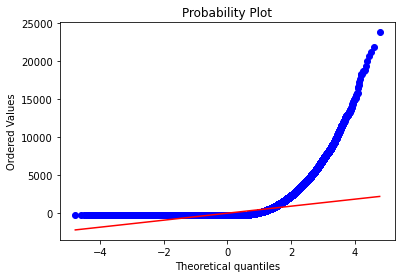

График 167


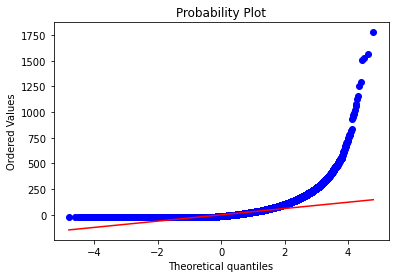

График 146


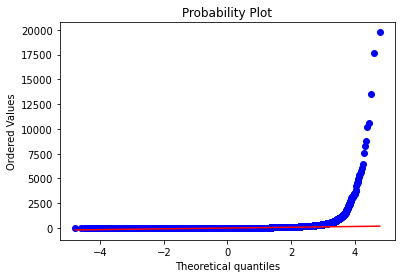

График 74


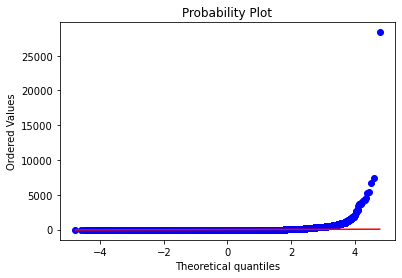

График 241


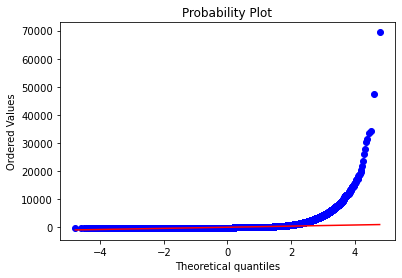

График 242


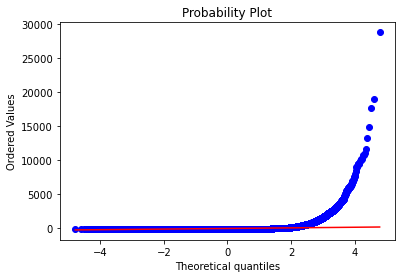

График 66


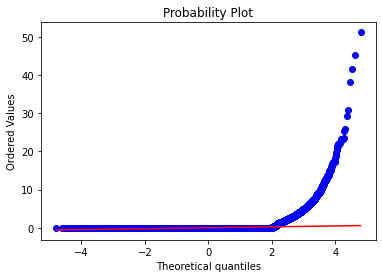

График 172


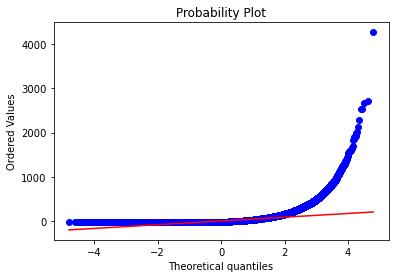

График 184


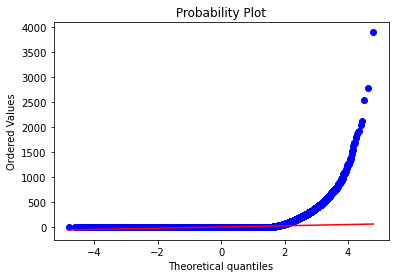

График 247


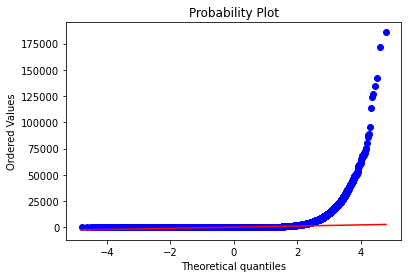

График 230


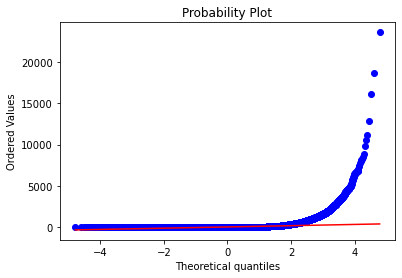

График 224


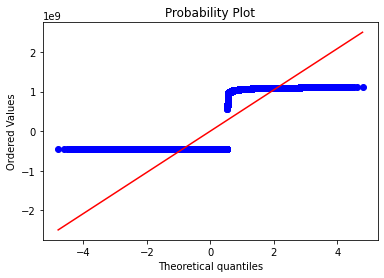

График 225


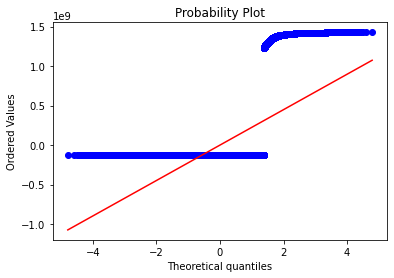

График 188


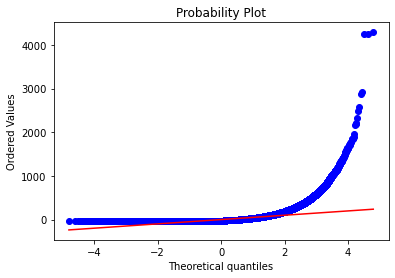

График 3


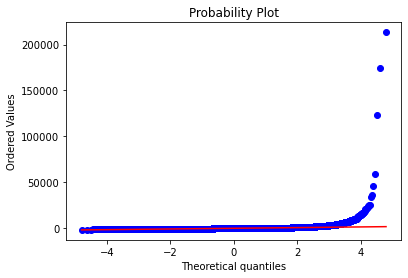

График 151


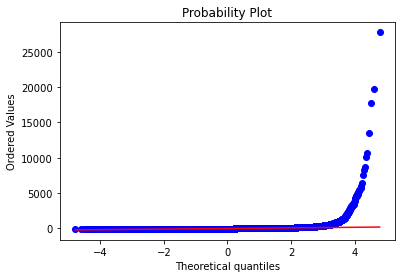

График 19


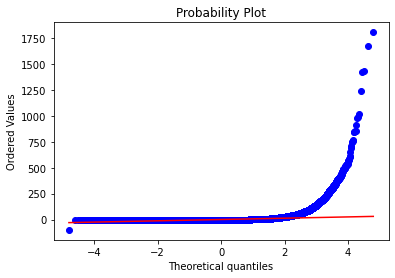

График 185


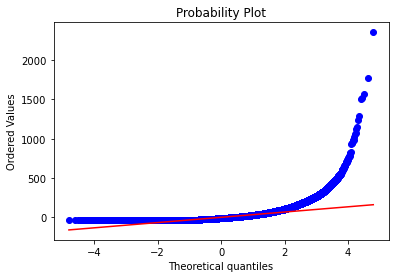

График id


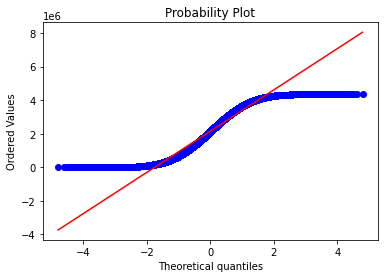

График 250


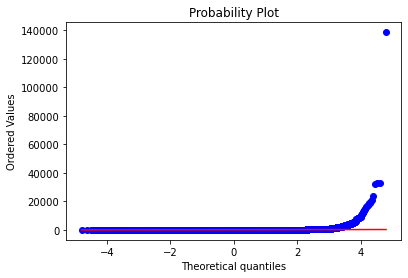

График 236


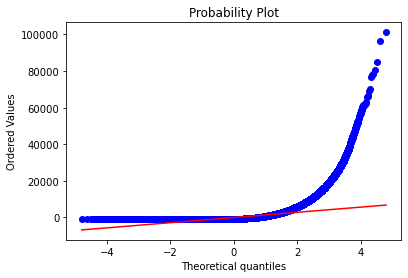

График 109


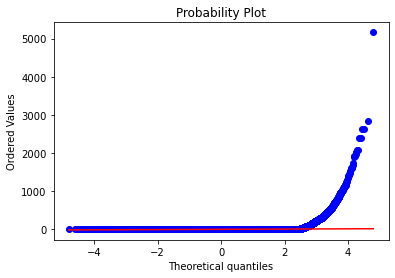

График 11


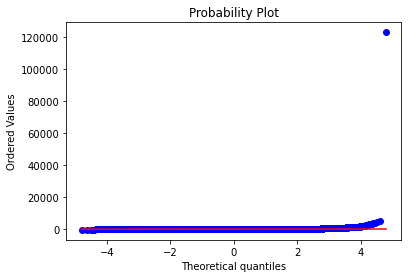

График 123


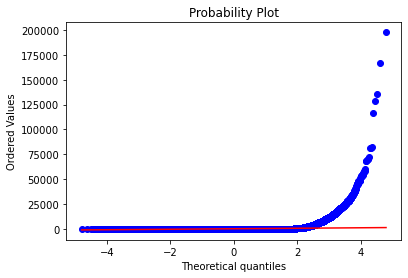

График 76


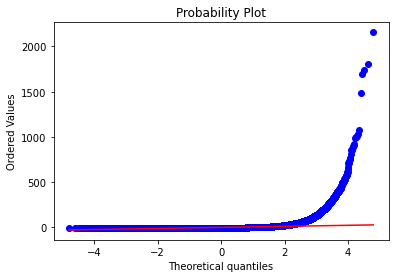

График 134


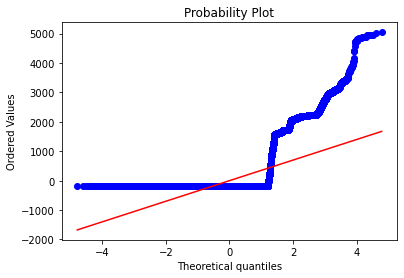

График 223


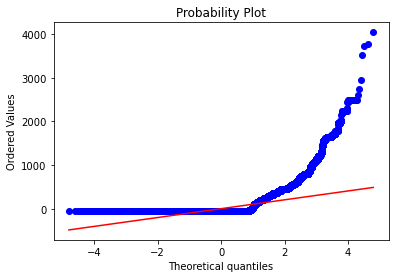

График 246


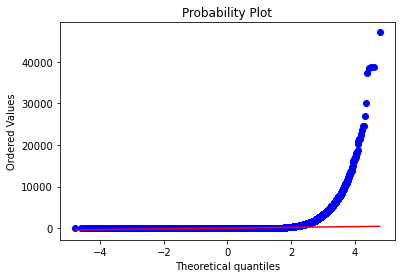

График 4


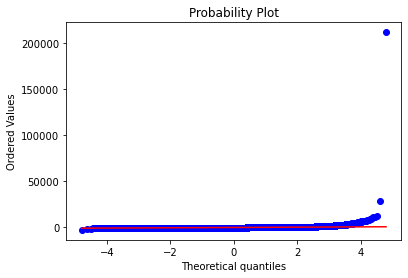

График 50


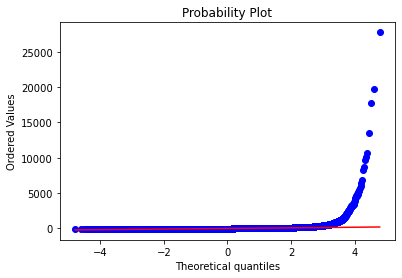

График 100


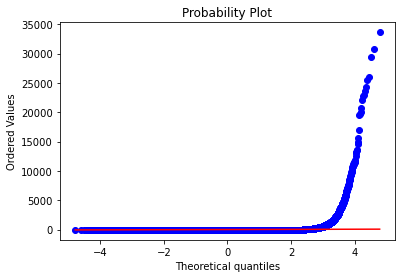

График 55


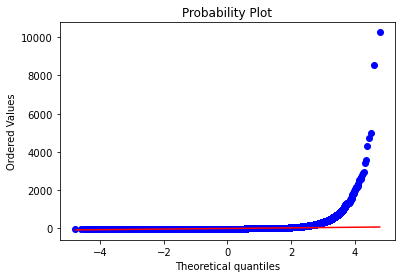

График 98


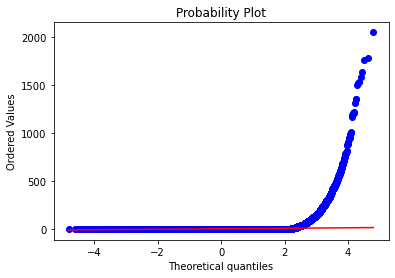

График 117


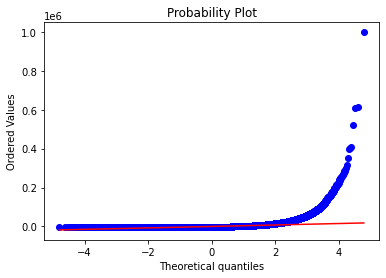

График 103


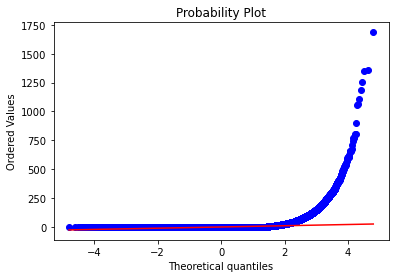

График 13


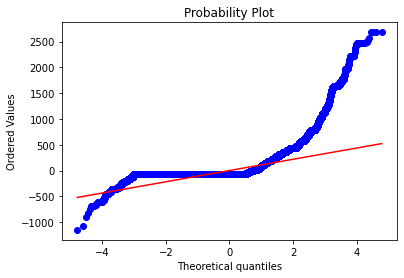

График 237


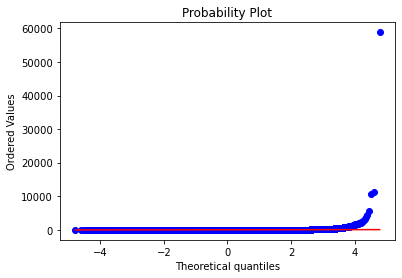

График 99


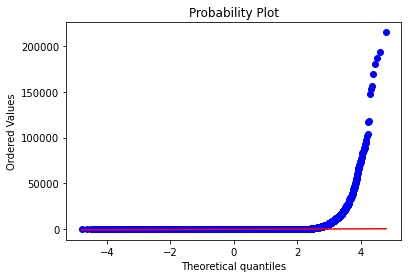

График 2


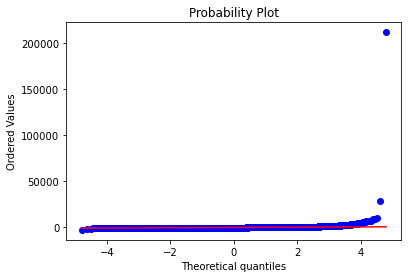

График 210


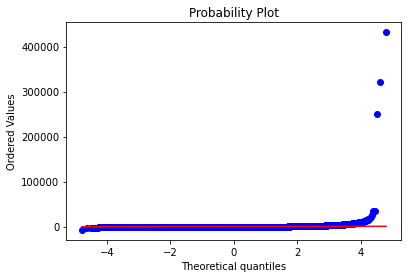

График 102


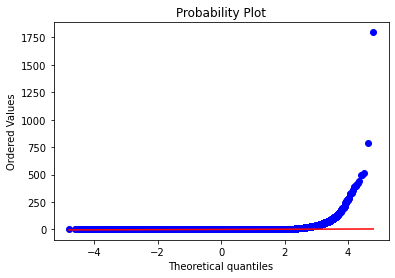

График 140


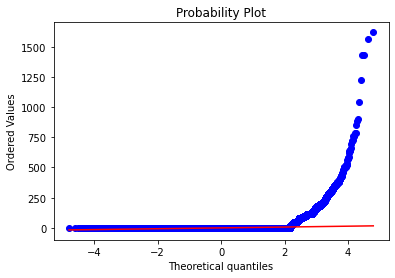

График 46


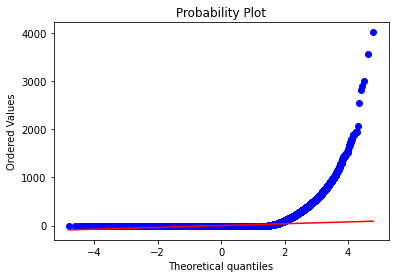

График 112


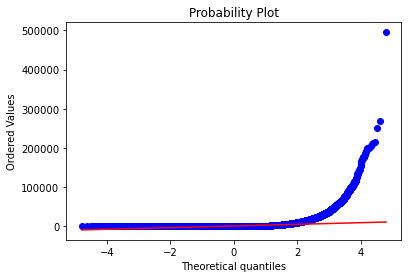

График 191


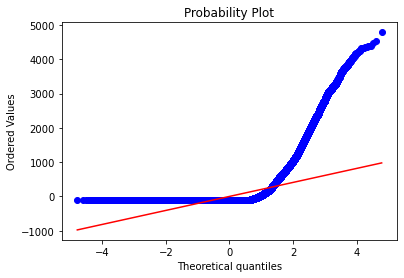

График 1


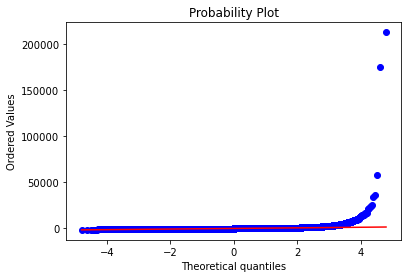

График 211


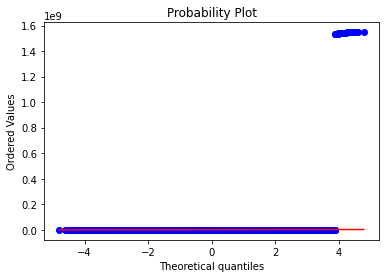

График 106


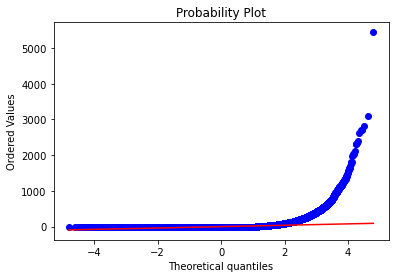

График 71


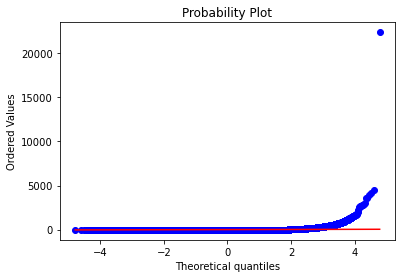

График 208


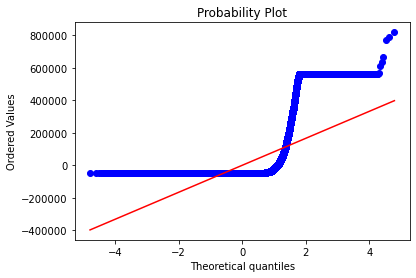

График 92


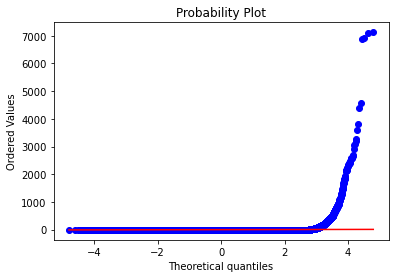

График 39


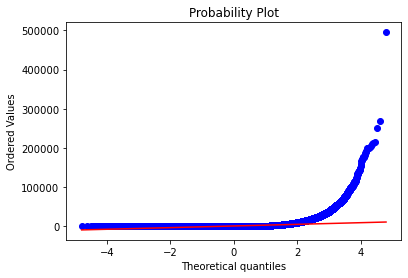

График 143


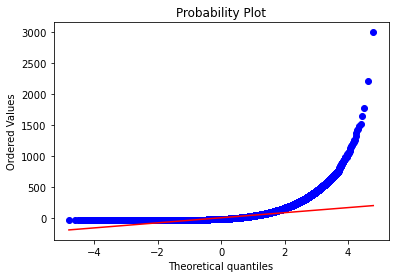

График 38


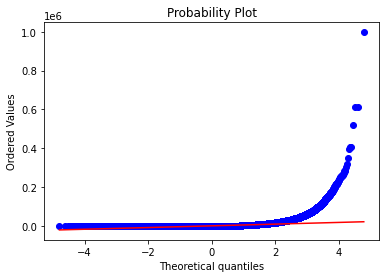

График 9


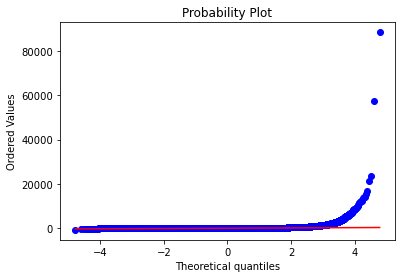

График 40


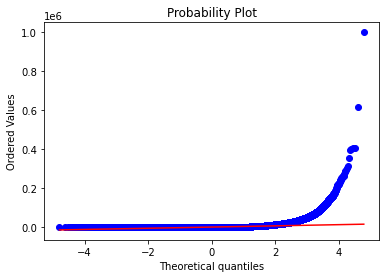

График 7


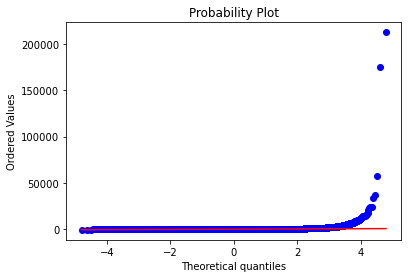

График 108


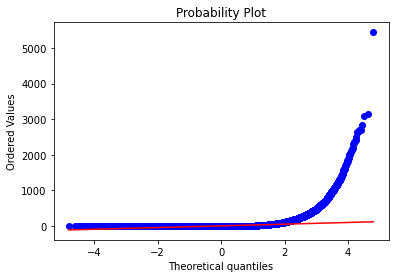

График 104


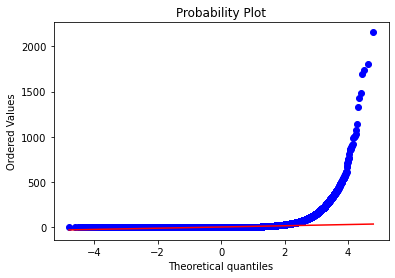

График 25


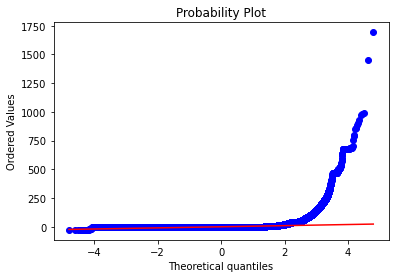

График 116


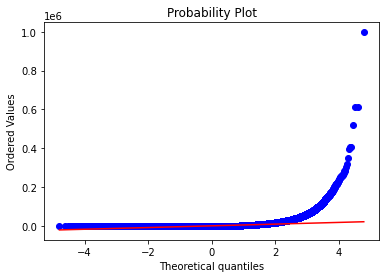

График 113


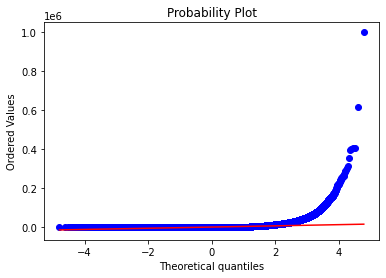

График 68


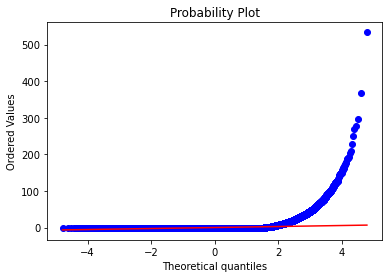

График 213


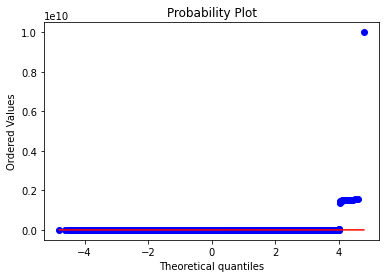

График 182


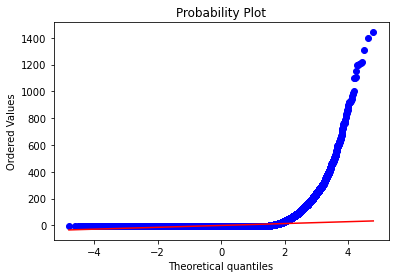

График 54


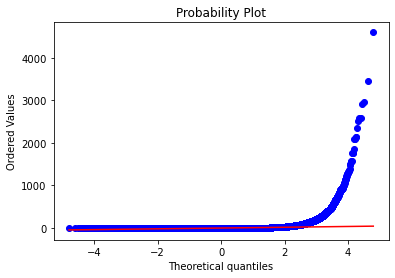

График 186


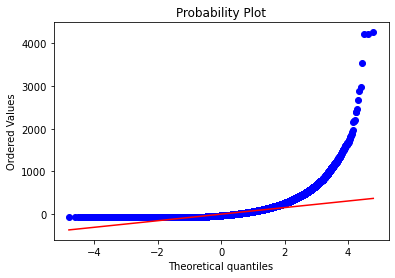

График 53


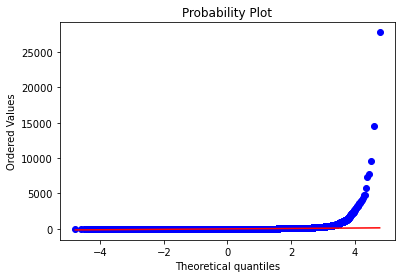

График 174


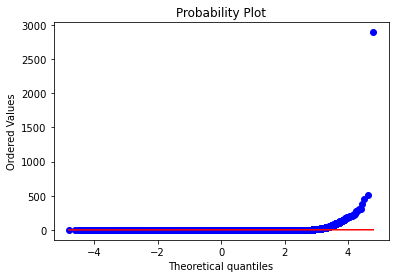

График 228


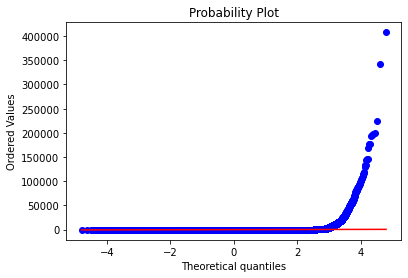

График 21


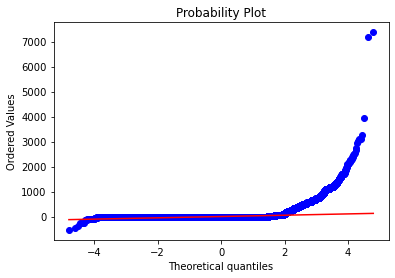

График 49


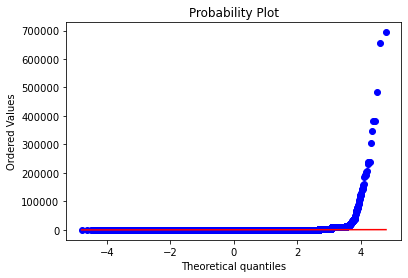

График 51


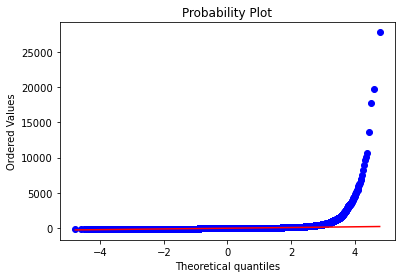

График 45


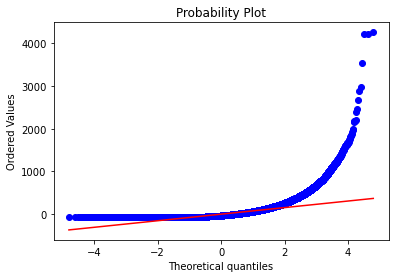

График 239


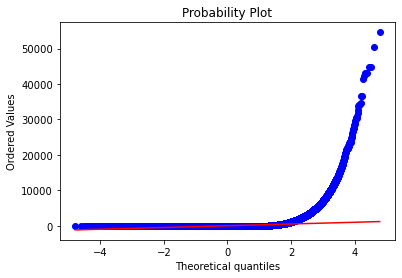

График 91


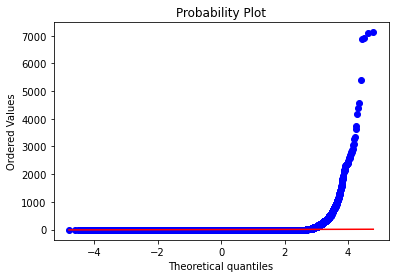

График 244


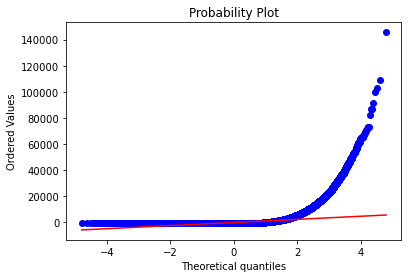

График 20


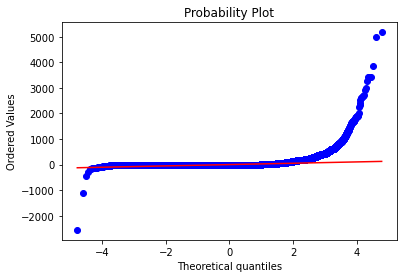

График 18


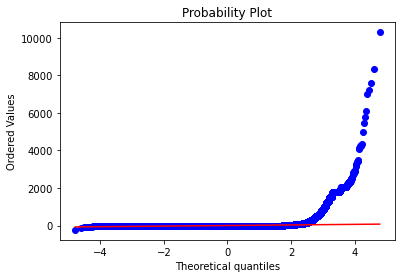

График 227


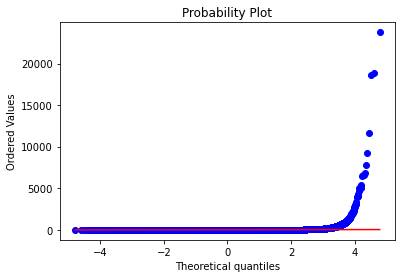

График 207


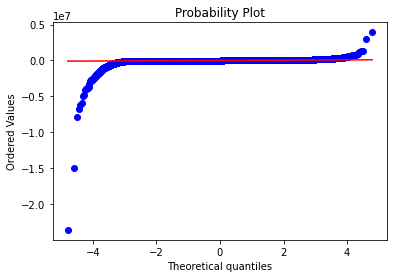

График 42


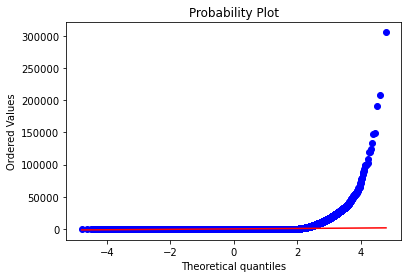

График 226


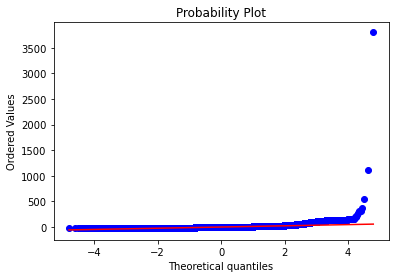

График 37


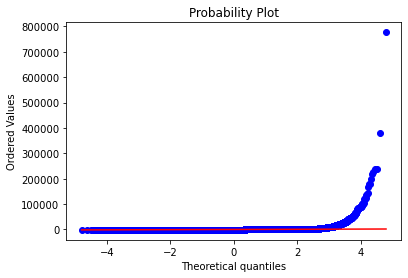

График 44


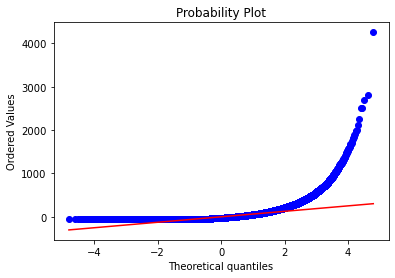

График 10


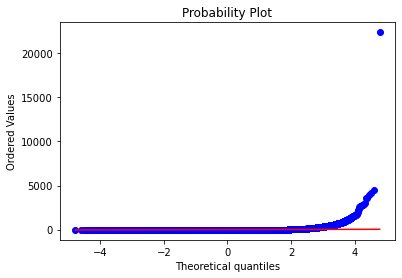

График 43


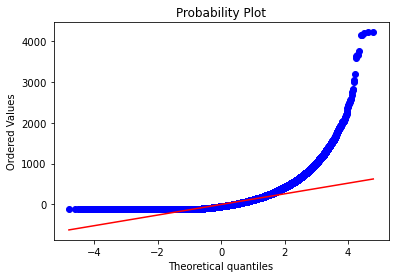

График 77


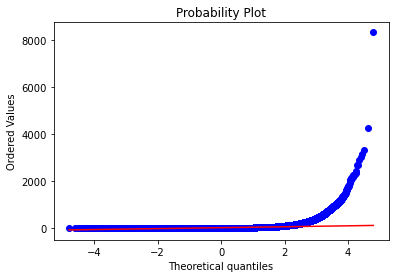

График 190


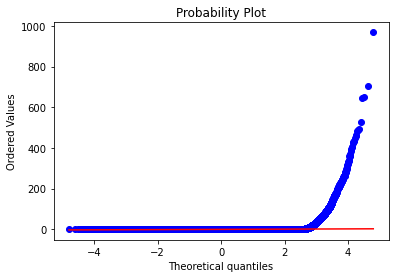

График 234


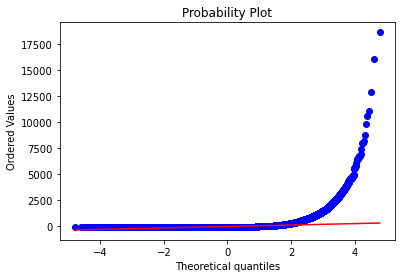

График 97


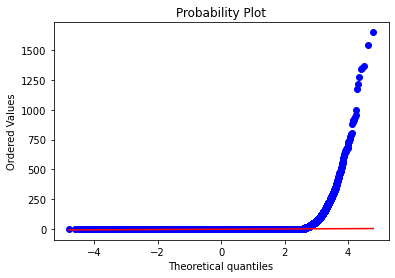

График 248


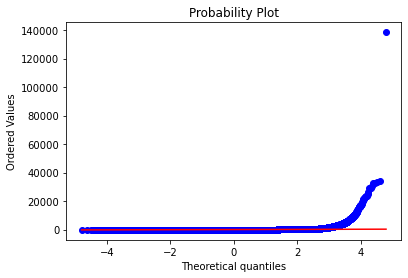

График 243


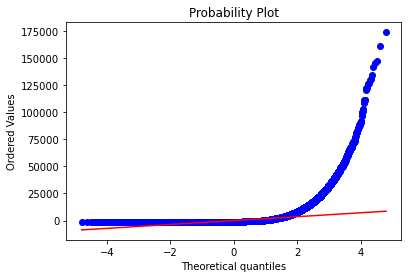

График 36


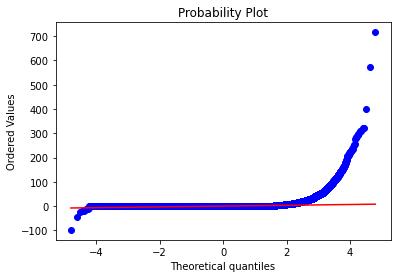

График 147


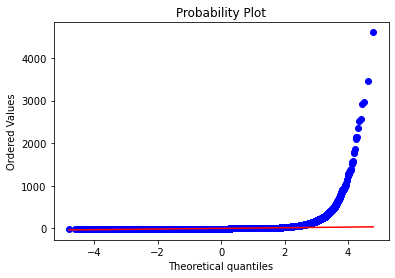

График 96


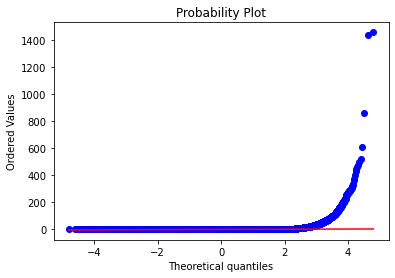

График 235


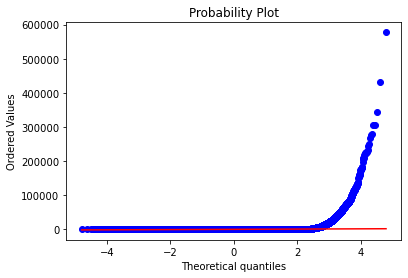

График 34


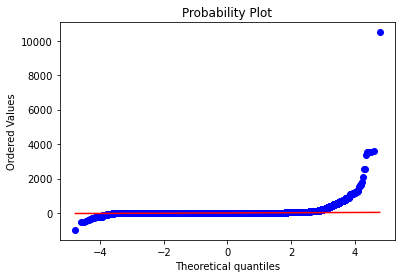

График 166


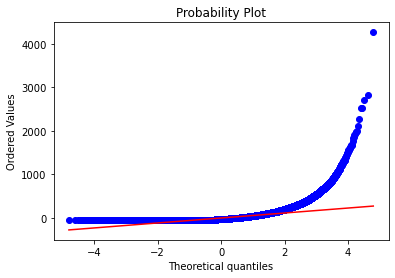

График 5


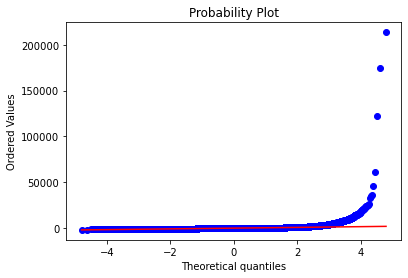

График 6


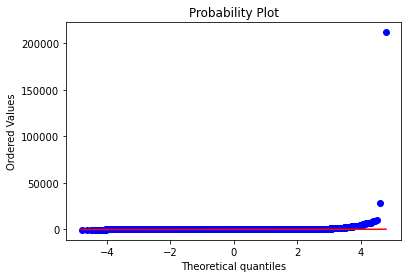

График 168


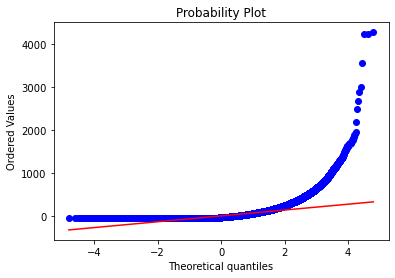

График 52


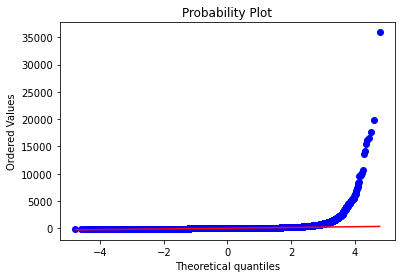

График 8


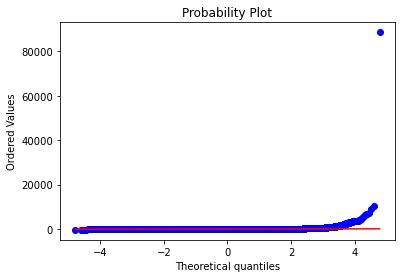

График 245


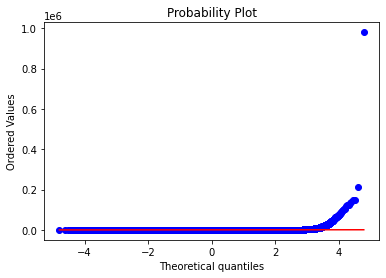

График 169


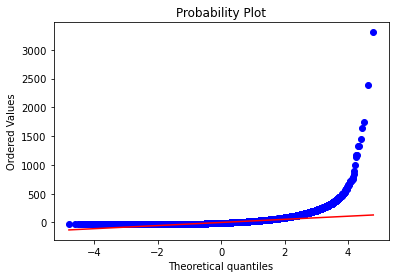

График 48


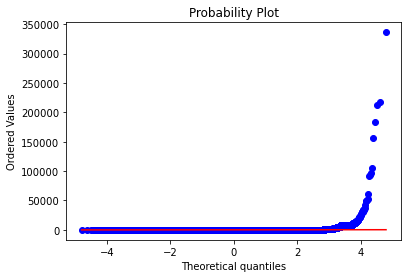

График 240


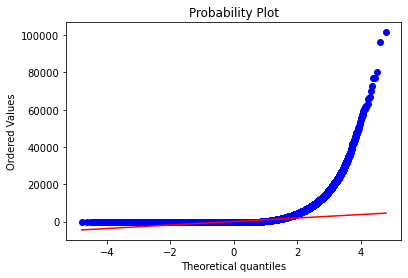

График 47


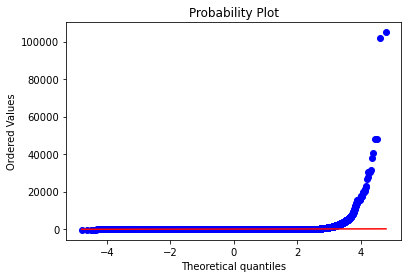

График 0


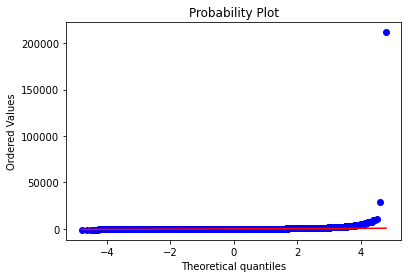

График 14


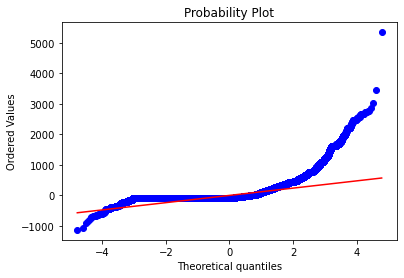

График 229


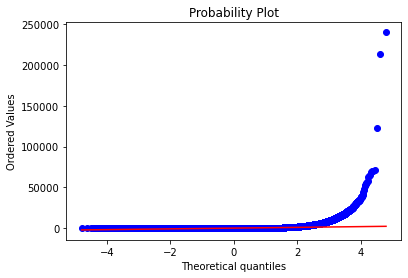

График 144


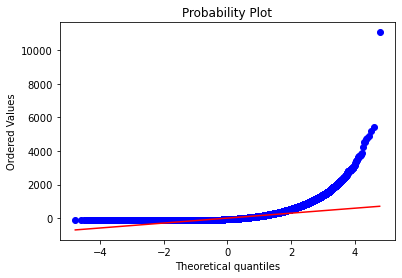

In [114]:
for i in big_nunique_features:
  print(f"График {i}")
  stats.probplot(df_selected[i], dist='norm', plot=pylab)
  pylab.show()

Выводы: не все распределения напоминают нормальные, практически у всех хвосты справа.
В список выбрал распределения у которых график близок к нормальному и хвосты начинаются со второй сигмы. У кого с третьей сигмы смысла ловить 0,1% нету. Индивидуальный подход к такому количеству признаков не будешь использовать.  Поэтому остановлюсь на обрезании верхних 2% по каждой из этих выборок.

In [115]:
sigma2 = ['246', '106', '147', '21', '234', '229', '186', '169', '42', '43', '123',
         '238', '243', '172', '66', '168', '45', '242', '144', '76', '230', '188', '38', '103', 
         '25', '244', '68', '18', '39', '116', '184', '55', '185', '140', '239', '36', '182', '77', 
         '247', '108', '98', '240', '46', '166', '19', '241', '112', '40', '54', '20', '117']

In [116]:
len(sigma2)

51

Создам функцию замены значений хвостов медианными значениями(увеличила на 1% метрику на самой плохой модели).

In [117]:
def imputer_sigma2(df, sigma_list):
    for col in sigma_list:
        condition = df[col] > df[col].quantile(.98)
        df.loc[condition, col] = df[col].median()
    return df

In [118]:
# Словарь с пороговыми значениями для удаления выбросов
sigma_dict = dict()

In [119]:
def imputer_sigma_dict(df, sigma_list, sigma_dict):
    for col in sigma_list:
        treshold = df[col].quantile(.98)
        sigma_dict[col] = treshold
    
    return sigma_dict

In [120]:
sigma_dict = imputer_sigma_dict(df_selected, sigma2, sigma_dict)

Пока, чтобы долго не возиться с кодом проверю метрику, обработав первоначальный датасет, потом, если метрика увеличится, sigma_dict буду обучать на трейне. Проверка показала что метрики не уменьшились. Надеюсь что преобразование поспособствует увеличению метрики при добавлении признаков.

In [121]:
def imputer_outliers(df, sigma_list, sigma_dict):
    for col in sigma_list:
        condition = df[col] > sigma_dict[col]
        df.loc[condition, col] = -999
    return df

In [122]:
df_selected = imputer_outliers(df_selected, sigma2, sigma_dict)

/home/jb/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [123]:
df_selected.isna().sum().sum()

0

# Проверка как изменилась метрика

# vas_id_1.0

In [124]:
df_1s = df_selected[importance_features1]
df_1s = df_1s[df_1s['vas_id_1.0']==1]
X_train1s, X_test1s, y_train1s, y_test1s, feature_importances1s =\
     choise_features(df_1s)

0.0    0.981738
1.0    0.018262
Name: target, dtype: float64

0.0    0.981742
1.0    0.018258
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    213157
         1.0       0.56      0.40      0.46      3965

    accuracy                           0.98    217122
   macro avg       0.77      0.69      0.73    217122
weighted avg       0.98      0.98      0.98    217122

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     91354
         1.0       0.54      0.39      0.45      1699

    accuracy                           0.98     93053
   macro avg       0.76      0.69      0.72     93053
weighted avg       0.98      0.98      0.98     93053

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     90788  566
1.0      1032  667


macro avg       0.77      0.69      0.72     93053

# vas_id_2.0

In [125]:
df_2s = df_selected[importance_features2]
df_2s = df_2s[df_2s['vas_id_2.0']==1]
X_train2s, X_test2s, y_train2s, y_test2s, feature_importances2s =\
     choise_features(df_2s)

0.0    0.980773
1.0    0.019227
Name: target, dtype: float64

0.0    0.980775
1.0    0.019225
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    171295
         1.0       0.66      0.55      0.60      3358

    accuracy                           0.99    174653
   macro avg       0.83      0.77      0.80    174653
weighted avg       0.98      0.99      0.99    174653

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     73413
         1.0       0.64      0.53      0.58      1439

    accuracy                           0.99     74852
   macro avg       0.82      0.76      0.79     74852
weighted avg       0.98      0.99      0.98     74852

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     72990  423
1.0       677  762


macro avg       0.82      0.76      0.78     74852

# vas_id_4.0

In [126]:
df_4s = df_selected[importance_features4]
df_4s = df_4s[df_4s['vas_id_4.0']==1]
X_train4s, X_test4s, y_train4s, y_test4s, feature_importances4s =\
     choise_features(df_4s)

0.0    0.746206
1.0    0.253794
Name: target, dtype: float64

0.0    0.746181
1.0    0.253819
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88     44794
         1.0       0.79      0.26      0.39     15235

    accuracy                           0.79     60029
   macro avg       0.79      0.62      0.63     60029
weighted avg       0.79      0.79      0.75     60029

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88     19197
         1.0       0.80      0.26      0.40      6530

    accuracy                           0.80     25727
   macro avg       0.80      0.62      0.64     25727
weighted avg       0.80      0.80      0.76     25727

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     18760   437
1.0      4807  1723


macro avg       0.80      0.62      0.64     25727

# vas_id_5.0

In [127]:
df_5s = df_selected[importance_features5]
df_5s = df_5s[df_5s['vas_id_5.0']==1]
X_train5s, X_test5s, y_train5s, y_test5s, feature_importances5s =\
     choise_features(df_5s)

0.0    0.982022
1.0    0.017978
Name: target, dtype: float64

0.0    0.982002
1.0    0.017998
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     64675
         1.0       0.69      0.58      0.63      1184

    accuracy                           0.99     65859
   macro avg       0.84      0.79      0.81     65859
weighted avg       0.99      0.99      0.99     65859

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     27718
         1.0       0.67      0.50      0.57       508

    accuracy                           0.99     28226
   macro avg       0.83      0.75      0.78     28226
weighted avg       0.99      0.99      0.99     28226

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     27593  125
1.0       253  255


macro avg       0.83      0.75      0.78     28226

# vas_id_6.0

In [128]:
df_6s = df_selected[importance_features6]
df_6s = df_6s[df_6s['vas_id_6.0']==1]
X_train6s, X_test6s, y_train6s, y_test6s, feature_importances6s =\
     choise_features(df_6s)

0.0    0.57316
1.0    0.42684
Name: target, dtype: float64

0.0    0.573197
1.0    0.426803
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.60      0.97      0.74     23221
         1.0       0.74      0.12      0.20     17293

    accuracy                           0.61     40514
   macro avg       0.67      0.54      0.47     40514
weighted avg       0.66      0.61      0.51     40514

TEST

              precision    recall  f1-score   support

         0.0       0.59      0.96      0.73      9953
         1.0       0.69      0.11      0.20      7411

    accuracy                           0.60     17364
   macro avg       0.64      0.54      0.46     17364
weighted avg       0.63      0.60      0.50     17364

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     9571  382
1.0     6568  843


macro avg       0.62      0.54      0.47     17364

# vas_id_7.0

In [129]:
df_7s = df_selected[importance_features7]
df_7s = df_7s[df_7s['vas_id_7.0']==1]
X_train7s, X_test7s, y_train7s, y_test7s, feature_importances7s =\
     choise_features(df_7s)

0.0    0.986206
1.0    0.013794
Name: target, dtype: float64

0.0    0.986177
1.0    0.013823
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     10653
         1.0       0.79      0.36      0.50       149

    accuracy                           0.99     10802
   macro avg       0.89      0.68      0.75     10802
weighted avg       0.99      0.99      0.99     10802

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      4566
         1.0       0.66      0.42      0.51        64

    accuracy                           0.99      4630
   macro avg       0.83      0.71      0.75      4630
weighted avg       0.99      0.99      0.99      4630

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     4552   14
1.0       37   27


macro avg       0.82      0.71      0.75      4630

# vas_id_8.0

In [130]:
df_8s = df_selected[importance_features8]
df_8s = df_8s[df_8s['vas_id_8.0']==1]
X_train8s, X_test8s, y_train8s, y_test8s, feature_importances8s =\
     choise_features(df_8s)

0.0    0.973997
1.0    0.026003
Name: target, dtype: float64

0.0    0.974032
1.0    0.025968
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      9102
         1.0       0.79      0.88      0.83       243

    accuracy                           0.99      9345
   macro avg       0.89      0.94      0.91      9345
weighted avg       0.99      0.99      0.99      9345

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3901
         1.0       0.63      0.82      0.71       104

    accuracy                           0.98      4005
   macro avg       0.81      0.90      0.85      4005
weighted avg       0.99      0.98      0.98      4005

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     3851   50
1.0       19   85


macro avg       0.82      0.90      0.85      4005

# vas_id_9.0

In [131]:
df_9s = df_selected[importance_features9]
df_9s = df_9s[df_9s['vas_id_9.0']==1]
X_train9s, X_test9s, y_train9s, y_test9s, feature_importances9s =\
     choise_features(df_9s)

0.0    0.816449
1.0    0.183551
Name: target, dtype: float64

0.0    0.816687
1.0    0.183313
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      3127
         1.0       0.91      0.86      0.88       703

    accuracy                           0.96      3830
   macro avg       0.94      0.92      0.93      3830
weighted avg       0.96      0.96      0.96      3830

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      1341
         1.0       0.92      0.86      0.89       301

    accuracy                           0.96      1642
   macro avg       0.94      0.92      0.93      1642
weighted avg       0.96      0.96      0.96      1642

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     1318   23
1.0       42  259


/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


macro avg       0.94      0.92      0.93      1642

Улучшения метрик не увидел, а значит важность операции не определена. Есть вероятность что она ошибочна.